In [35]:
import numpy as np
from scipy import optimize
from scipy.stats import multivariate_normal, norm
from scipy.integrate import dblquad, tplquad
import matplotlib.pyplot as plt
import itertools

# **R5: Multiple Products Non-Stationary Environment**

Multiple product pricing with smoothly changing buyer preferences over time. 

Uses sliding window UCB with two regret analyses:
- A Priori: Against best fixed strategy
- A Posteriori: Against optimal strategy at each time step

## Optimal Strategy

Linear program to find optimal price distribution maximizing revenue subject to capacity constraint.

In [36]:
def compute_win_probabilities_joint(prices, buyer, num_samples=50000):
    num_products = len(buyer.mu)
    num_prices = len(prices)

    valuations = np.random.multivariate_normal(buyer.mu, buyer.sigma, size=num_samples)
    win_probabilities = np.zeros((num_products, num_prices))

    for j in range(num_products):
        for p_idx, price_j in enumerate(prices):
            count_greater = np.sum(valuations[:, j] > price_j)
            win_probabilities[j, p_idx] = count_greater / num_samples

    return win_probabilities

In [37]:
def compute_best_prices_multi_product(prices, rho, buyer, num_samples=50000):
    prices = np.array(prices)
    K = len(prices)
    N = len(buyer.mu)
    
    win_probs = compute_win_probabilities_joint(prices, buyer, num_samples)
    
    gamma_matrix = np.zeros((N, K))
    expected_revenue = 0
    expected_units_sold = 0
    
    for i in range(N):
        f = win_probs[i] * prices  # expected revenue per price
        c = -f                    # we minimize, so negate
        
        A_ub = [win_probs[i]]     # expected units sold ≤ rho
        b_ub = [rho]
        A_eq = [np.ones(K)]       # sum of probabilities = 1
        b_eq = [1]
        bounds = [(0, 1)] * K
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                               A_eq=A_eq, b_eq=b_eq,
                               bounds=bounds, method='highs')
        
        if res.success:
            gamma = res.x
            gamma_matrix[i] = gamma
            expected_revenue += np.dot(gamma, f)
            expected_units_sold += np.dot(gamma, win_probs[i])
        else:
            raise ValueError(f"LP failed for product {i}: {res.message}")
    
    return gamma_matrix, expected_revenue, expected_units_sold

## Non-Stationary Buyer Model

Buyer with smoothly changing mean valuations over time horizon T.

In [38]:
class Buyer:
    def __init__(self, mu, sigma):
        self.mu = np.array(mu)
        self.sigma = np.array(sigma)
        self.dimension = self.mu.shape[0]

    def round(self, prices):
        valuations = np.random.multivariate_normal(self.mu, self.sigma)
        prices = np.array(prices)

        return (valuations > prices).astype(int)

In [46]:
class NonStationaryBuyer:
    def __init__(self, T):
        # Predetermined transitions
        self.initial_mu = np.array([0.6, 0.5, 0.7])
        self.target_mu = np.array([0.4, 0.8, 0.5])
        self.current_mu = self.initial_mu.copy()
        
        # Fixed covariance matrix
        self.sigma = np.array([[0.1, 0.05, 0.02],
                              [0.05, 0.1, 0.03],
                              [0.02, 0.03, 0.1]])
        
        self.dimension = 3
        self.T = T
        self.round_count = 0
        
        # Store history for analysis
        self.mu_history = [(0, self.current_mu.copy())]

    def round(self, prices):
        # Update distribution smoothly
        self._update_distribution()
        
        # Generate valuations from current distribution
        valuations = np.random.multivariate_normal(self.current_mu, self.sigma)
        prices = np.array(prices)

        self.round_count += 1
        return (valuations > prices).astype(int)
    
    def _update_distribution(self):
        if self.round_count < self.T:
            # Linear interpolation from initial_mu to target_mu
            progress = self.round_count / self.T
            self.current_mu = self.initial_mu + progress * (self.target_mu - self.initial_mu)
        else:
            # Stay at target after T rounds
            self.current_mu = self.target_mu.copy()
        
        # Store for analysis (every 100 rounds to save memory)
        if self.round_count % 100 == 0:
            self.mu_history.append((self.round_count, self.current_mu.copy()))

    def get_current_params(self):
        return {
            'mu': self.current_mu.copy(),
            'sigma': self.sigma,
            'round': self.round_count
        }

mean plot during time

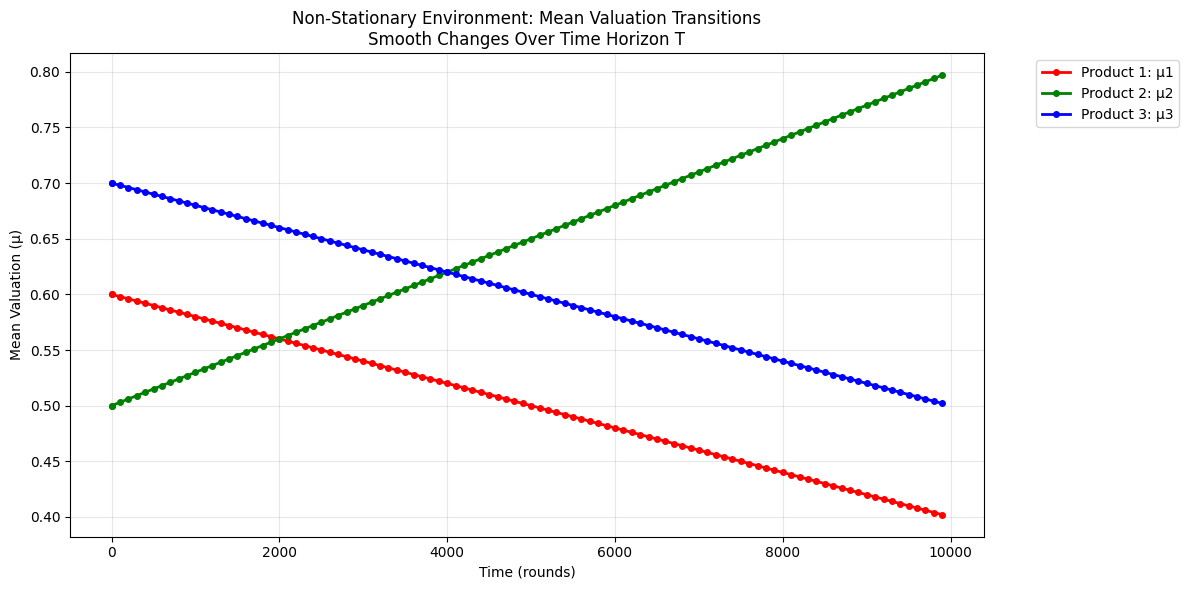

In [40]:
buyer = NonStationaryBuyer(T=10000)
# Example usage
for _ in range(10000):
    prices = [0.5, 0.6, 0.7]  # Example prices
    buyer.round(prices)

# Plot the mean variation over time
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Extract time points and mean values from buyer's history
time_points = [entry[0] for entry in buyer.mu_history]
mu_values = np.array([entry[1] for entry in buyer.mu_history])

# Plot each product's mean variation
colors = ['red', 'green', 'blue']
product_names = ['Product 1', 'Product 2', 'Product 3']

for i in range(3):
    ax.plot(time_points, mu_values[:, i], 
            color=colors[i], linewidth=2, marker='o', markersize=4,
            label=f'{product_names[i]}: μ{i+1}')

ax.set_xlabel('Time (rounds)')
ax.set_ylabel('Mean Valuation (μ)')
ax.set_title('Non-Stationary Environment: Mean Valuation Transitions\nSmooth Changes Over Time Horizon T')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Company Strategy: Sliding Window UCB

Combinatorial UCB with sliding window for adaptation to changing environments. Window size W=2500 maintains only recent observations.

In [41]:
class SlidingWindowCombinatorial_UCB:
    def __init__(self, K, B, T, N, window_size=2500, range_factor=1):
        self.K = K
        self.T = T
        self.N = N
        self.W = window_size
        self.range = range_factor
        self.s_t = None
        
        self.budget = B
        self.rho = B / T
        self.t = 0
        
        # Sliding window storage for each product-price pair
        self.windows = {}
        for n in range(N):
            for k in range(K):
                self.windows[(n, k)] = {'rewards': [], 'costs': []}
        
        # Current estimates
        self.avg_f = np.zeros((N, K))
        self.avg_c = np.zeros((N, K))
        self.N_pulls = np.zeros((N, K))
        
    def pull_superarm(self):
        if self.budget < 1:
            self.s_t = np.zeros(self.N, dtype=int)
            return self.s_t
        
        # Update estimates from sliding windows
        self._update_estimates()
        
        # Compute UCB bounds
        f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        
        # Solve optimization
        gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)
        gamma_m[gamma_m < 1e-10] = 0
        
        # Sample super-arm
        self.s_t = np.zeros(self.N, dtype=int)
        for i in range(self.N):
            if np.sum(gamma_m[i]) > 0:
                gamma_m[i] = gamma_m[i] / np.sum(gamma_m[i])
                self.s_t[i] = np.random.choice(self.K, p=gamma_m[i])
            else:
                self.s_t[i] = 0
                
        return self.s_t
    
    def _update_estimates(self):
        for n in range(self.N):
            for k in range(self.K):
                window = self.windows[(n, k)]
                if len(window['rewards']) > 0:
                    self.avg_f[n, k] = np.mean(window['rewards'])
                    self.avg_c[n, k] = np.mean(window['costs'])
                    self.N_pulls[n, k] = len(window['rewards'])
                else:
                    self.avg_f[n, k] = 0
                    self.avg_c[n, k] = 0
                    self.N_pulls[n, k] = 0
    
    def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):
        N, K = f_ucbs_matrix.shape
        gamma_matrix = np.zeros((N, K))
        
        for i in range(N):
            f_ucbs = f_ucbs_matrix[i]
            c_lcbs = c_lcbs_matrix[i]
            
            if np.all(c_lcbs <= 0):
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                continue
                
            c = -f_ucbs
            A_ub = [c_lcbs]
            b_ub = [self.rho]
            A_eq = [np.ones(K)]
            b_eq = [1]
            bounds = [(0, 1) for _ in range(K)]
            
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                gamma_matrix[i] = res.x
            else:
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                
        return gamma_matrix
    
    def update(self, f_t, c_t, p_t, n_t):
        window = self.windows[(n_t, p_t)]
        
        # Add new observation
        window['rewards'].append(f_t)
        window['costs'].append(c_t)
        
        # Maintain sliding window size
        if len(window['rewards']) > self.W:
            window['rewards'].pop(0)
            window['costs'].pop(0)
        
        # Update budget and time
        self.budget -= c_t
        self.t += 1

    def get_current_params(self):
        return {
            'mu': self.current_mu.copy(),
            'sigma': self.sigma,
            'round': self.round_count
        }

## Simulation Setup

Experimental parameters and non-stationary transitions.

In [42]:
# Experiment setup
T = 10000
B = 16000
W = 2500  # Sliding window size

P = np.linspace(0, 1, 11)
K = len(P)
N = 3

# Fixed covariance matrix
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

# Non-stationarity: predetermined smooth transitions
initial_mu = [0.6, 0.5, 0.7]
target_mu = [0.4, 0.6, 0.5]

In [43]:
# Compute initial optimal strategy (for reference)
buyer_initial = Buyer(initial_mu, sigma)
initial_gamma, initial_exp_utility, initial_expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer_initial)

print(f"Initial optimal strategy:")
print(f"Gamma: {initial_gamma}")
print(f"Expected utility: {initial_exp_utility}")
print(f"Expected units sold: {initial_expected_units_sold}")

# Compute target optimal strategy (for reference)
buyer_target = Buyer(target_mu, sigma)
target_gamma, target_exp_utility, target_expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer_target)

print(f"\nTarget optimal strategy:")
print(f"Gamma: {target_gamma}")
print(f"Expected utility: {target_exp_utility}")
print(f"Expected units sold: {target_expected_units_sold}")

Initial optimal strategy:
Gamma: [[ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Expected utility: 0.9348380000000001
Expected units sold: 1.74504

Target optimal strategy:
Gamma: [[ 0.  0.  0. -0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  1.  0.  0.  0.  0.  0.]]
Expected utility: 0.7615160000000001
Expected units sold: 1.6225


## Experiment 1: A Priori Regret

Regret against best fixed strategy (average of initial and target optimal utilities).

In [44]:
optimal_utility_a_priori = (initial_exp_utility + target_exp_utility) / 2
print(f"\nA priori optimal utility (average): {optimal_utility_a_priori:.4f}")

n_trials = 5
regret_per_trial_a_priori = []

for seed in range(n_trials):
    print(f"A Priori Trial {seed + 1}")
    
    np.random.seed(seed)
    
    # Create non-stationary buyer
    buyer = NonStationaryBuyer(T)
    
    # Create sliding window agent
    agent = SlidingWindowCombinatorial_UCB(K=K, B=B, T=T, N=N, window_size=W)
    
    # Track performance
    ag_utility = np.zeros(T)
    
    flag = True
    for t in range(T):
        # Agent selects super-arm
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        
        # Buyer responds
        sold = buyer.round(prices)
        
        # Compute rewards and update agent
        total_reward = 0
        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]
            
            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0
            
            total_reward += f_t
            agent.update(f_t=f_t, c_t=c_t, p_t=p_t, n_t=n_t)
        
        ag_utility[t] = total_reward
        
        if agent.budget <= 0 and flag:
            print(f"  Budget exhausted at round {t}")
            flag = False
    
    # Compute regret using a priori optimal utility (best fixed strategy)
    cumulative_regret = np.cumsum(optimal_utility_a_priori - ag_utility)
    regret_per_trial_a_priori.append(cumulative_regret)
    
    print(f"  Final budget: {agent.budget:.2f}")
    print(f"  Cumulative reward: {np.sum(ag_utility):.2f}")
    print(f"  Final regret: {cumulative_regret[-1]:.2f}")

# Aggregate results for A Priori
regret_per_trial_a_priori = np.array(regret_per_trial_a_priori)
average_regret_a_priori = regret_per_trial_a_priori.mean(axis=0)
regret_std_a_priori = regret_per_trial_a_priori.std(axis=0)

print(f"\nA PRIORI RESULTS:")
print(f"Average final regret: {average_regret_a_priori[-1]:.2f}")
print(f"Regret standard deviation: {regret_std_a_priori[-1]:.2f}")


A priori optimal utility (average): 0.8482
A Priori Trial 1
  Budget exhausted at round 9458
  Final budget: -1537.00
  Cumulative reward: 7511.60
  Final regret: 970.17
A Priori Trial 2
  Budget exhausted at round 9377
  Final budget: -1767.00
  Cumulative reward: 7263.00
  Final regret: 1218.77
A Priori Trial 3
  Budget exhausted at round 9373
  Final budget: -1764.00
  Cumulative reward: 7259.20
  Final regret: 1222.57
A Priori Trial 4
  Budget exhausted at round 9354
  Final budget: -1837.00
  Cumulative reward: 7349.00
  Final regret: 1132.77
A Priori Trial 5
  Budget exhausted at round 9390
  Final budget: -1722.00
  Cumulative reward: 7368.30
  Final regret: 1113.47

A PRIORI RESULTS:
Average final regret: 1131.55
Regret standard deviation: 91.94


## Experiment 2: A Posteriori Regret

Regret against optimal strategy at each time step considering true distribution.

In [ ]:
regret_per_trial_a_posteriori = []

for seed in range(n_trials):
    print(f"A Posteriori Trial {seed + 1}")
    
    np.random.seed(seed)
    
    # Create non-stationary buyer
    buyer = NonStationaryBuyer(T)
    
    # Create sliding window agent
    agent = SlidingWindowCombinatorial_UCB(K=K, B=B, T=T, N=N, window_size=W)
    
    # Track performance
    ag_utility = np.zeros(T)
    optimal_utility_per_round = np.zeros(T)  # A posteriori optimal utility per round
    
    flag = True
    for t in range(T):
        # Agent selects super-arm
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        
        # Buyer responds
        sold = buyer.round(prices)
        
        # Compute rewards and update agent
        total_reward = 0
        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]
            
            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0
            
            total_reward += f_t
            agent.update(f_t=f_t, c_t=c_t, p_t=p_t, n_t=n_t)
        
        ag_utility[t] = total_reward
        
        # Compute a posteriori optimal utility for current distribution
        current_params = buyer.get_current_params()
        buyer_current = Buyer(current_params['mu'], current_params['sigma'])
        _, opt_utility, _ = compute_best_prices_multi_product(P, B/T, buyer_current)
        optimal_utility_per_round[t] = opt_utility
        
        if agent.budget <= 0 and flag:
            print(f"  Budget exhausted at round {t}")
            flag = False
    
    # Compute regret using a posteriori optimal utility (time-varying optimal)
    cumulative_regret = np.cumsum(optimal_utility_per_round - ag_utility)
    regret_per_trial_a_posteriori.append(cumulative_regret)
    
    print(f"  Final budget: {agent.budget:.2f}")
    print(f"  Cumulative reward: {np.sum(ag_utility):.2f}")
    print(f"  Final regret: {cumulative_regret[-1]:.2f}")

# Aggregate results for A Posteriori
regret_per_trial_a_posteriori = np.array(regret_per_trial_a_posteriori)
average_regret_a_posteriori = regret_per_trial_a_posteriori.mean(axis=0)
regret_std_a_posteriori = regret_per_trial_a_posteriori.std(axis=0)

print(f"\nA POSTERIORI RESULTS:")
print(f"Average final regret: {average_regret_a_posteriori[-1]:.2f}")
print(f"Regret standard deviation: {regret_std_a_posteriori[-1]:.2f}")

A Posteriori Trial 1


## Results

Sublinear regret achieved with $O(T^{2/3} log T)$ and $O(T^{2/3} )$ bounds.

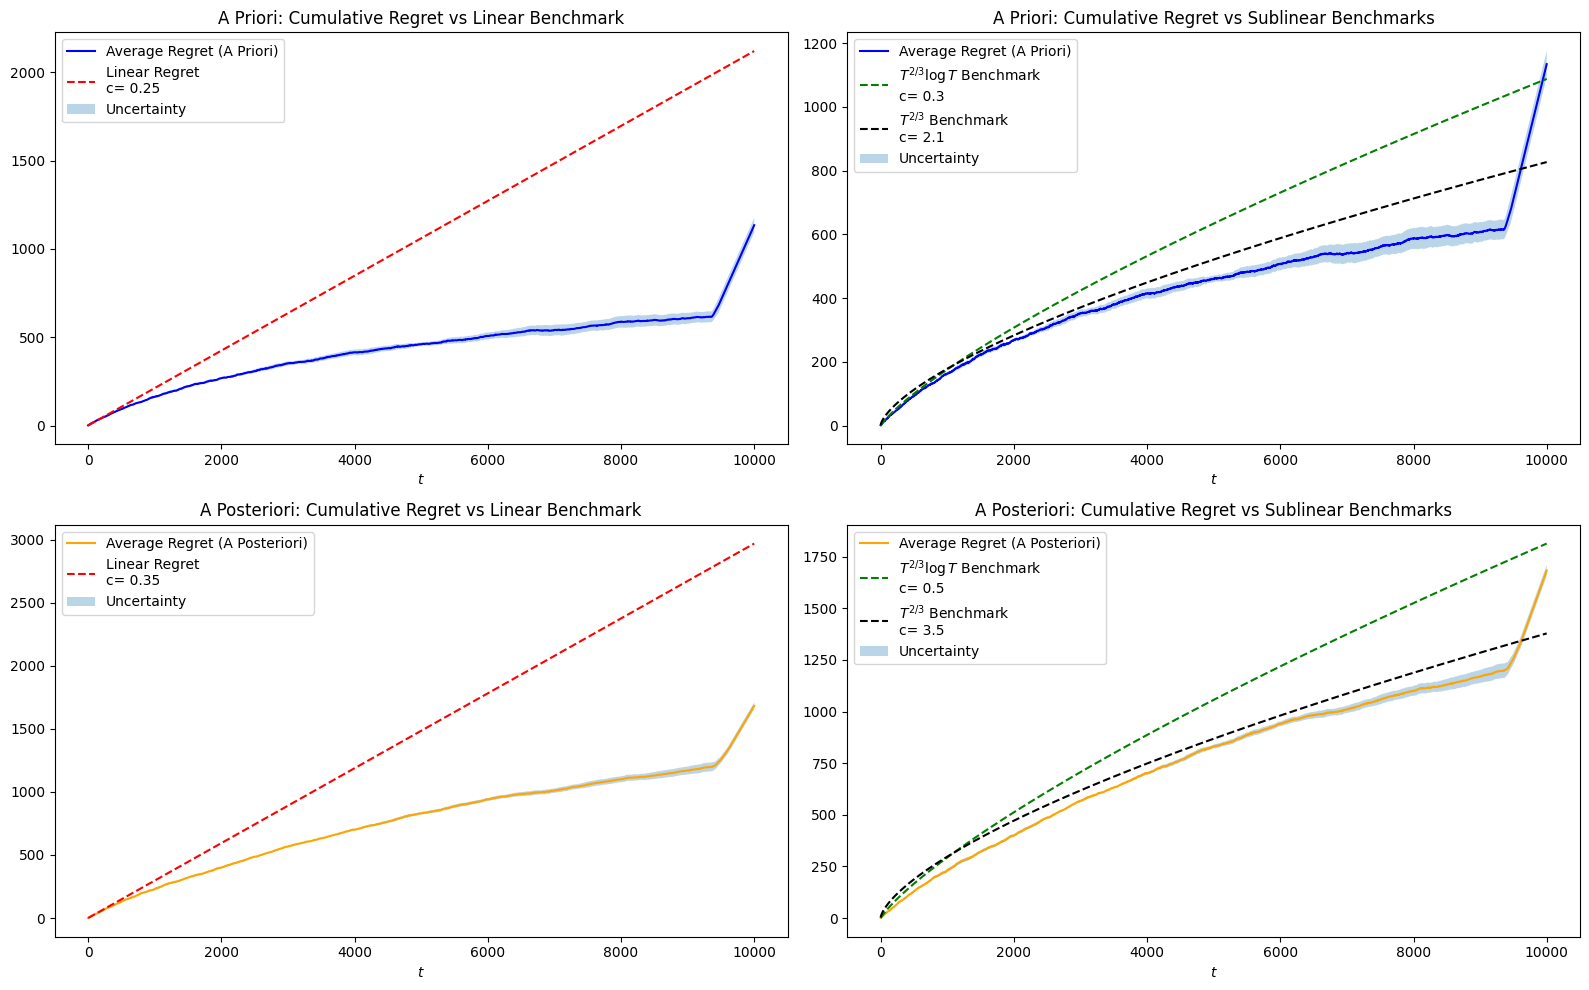

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# A PRIORI RESULTS
# ================

# A Priori - First subplot: Cumulative regret with linear line 
axs[0,0].plot(np.arange(T), average_regret_a_priori, label='Average Regret (A Priori)', color='blue')
axs[0,0].set_title('A Priori: Cumulative Regret vs Linear Benchmark')

c_linear = 0.25
linear_regret = np.arange(T) * optimal_utility_a_priori * c_linear
axs[0,0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc= {c_linear}', linestyle='--', color='red')
axs[0,0].fill_between(
    np.arange(T),
    average_regret_a_priori - regret_std_a_priori / np.sqrt(n_trials),
    average_regret_a_priori + regret_std_a_priori / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0,0].set_xlabel('$t$')
axs[0,0].legend()

# A Priori - Second subplot: T^{2/3} benchmark
axs[0,1].plot(np.arange(T), average_regret_a_priori, label='Average Regret (A Priori)', color='blue')
axs[0,1].set_title('A Priori: Cumulative Regret vs Sublinear Benchmarks')
t_vals = np.arange(1, T+1)
c_log = 0.3
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * optimal_utility_a_priori * c_log
axs[0,1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\nc= {c_log}', linestyle='--', color='green')
c_no_log = 2.1
benchmark = (t_vals ** (2/3)) * optimal_utility_a_priori * c_no_log
axs[0,1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\nc= {c_no_log}', linestyle='--', color='black')

axs[0,1].fill_between(
    np.arange(T),
    average_regret_a_priori - regret_std_a_priori / np.sqrt(n_trials),
    average_regret_a_priori + regret_std_a_priori / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0,1].set_xlabel('$t$')
axs[0,1].legend()

# A POSTERIORI RESULTS
# ====================

# A Posteriori - First subplot: Cumulative regret with linear line
c_linear = 0.35
avg_optimal_utility = np.mean([initial_exp_utility, target_exp_utility])
axs[1,0].plot(np.arange(T), average_regret_a_posteriori, label='Average Regret (A Posteriori)', color='orange')
axs[1,0].set_title('A Posteriori: Cumulative Regret vs Linear Benchmark')

linear_regret = np.arange(T) * avg_optimal_utility * c_linear
axs[1,0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc= {c_linear}', linestyle='--', color='red')
axs[1,0].fill_between(
    np.arange(T),
    average_regret_a_posteriori - regret_std_a_posteriori / np.sqrt(n_trials),
    average_regret_a_posteriori + regret_std_a_posteriori / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[1,0].set_xlabel('$t$')
axs[1,0].legend()

# A Posteriori - Second subplot: T^{2/3} benchmark
c_log = 0.5
c_no_log = 3.5
axs[1,1].plot(np.arange(T), average_regret_a_posteriori, label='Average Regret (A Posteriori)', color='orange')
axs[1,1].set_title('A Posteriori: Cumulative Regret vs Sublinear Benchmarks')
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * avg_optimal_utility * c_log
axs[1,1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\nc= {c_log}', linestyle='--', color='green')
benchmark = (t_vals ** (2/3)) * avg_optimal_utility * c_no_log
axs[1,1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\nc= {c_no_log}', linestyle='--', color='black')

axs[1,1].fill_between(
    np.arange(T),
    average_regret_a_posteriori - regret_std_a_posteriori / np.sqrt(n_trials),
    average_regret_a_posteriori + regret_std_a_posteriori / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[1,1].set_xlabel('$t$')
axs[1,1].legend()

plt.tight_layout()
plt.show()

comparison

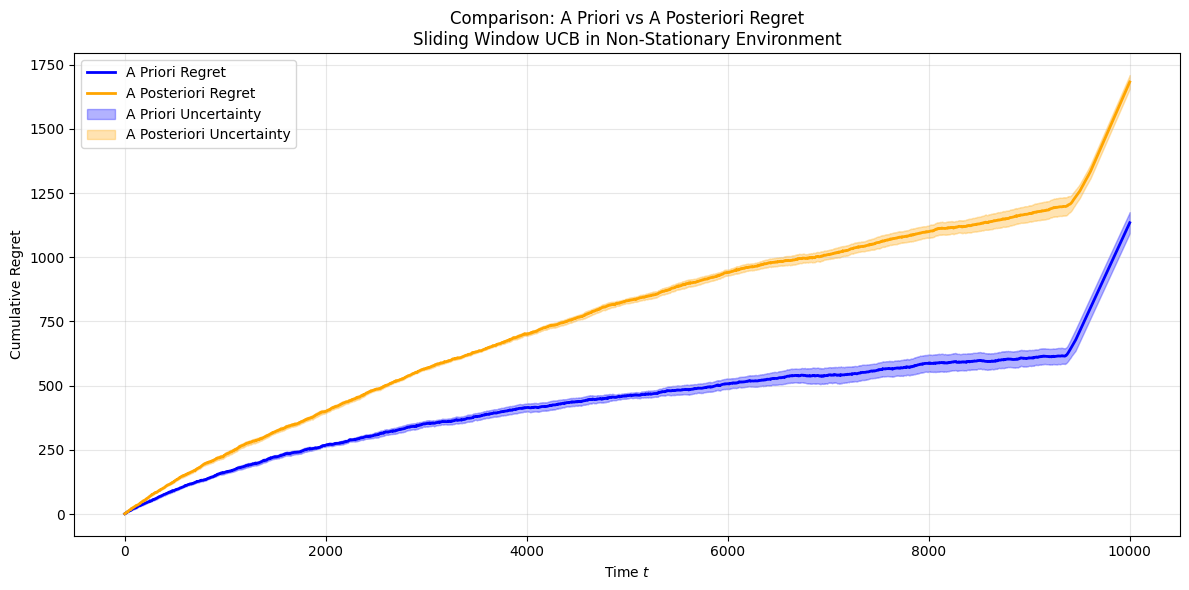

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot both regret curves
ax.plot(np.arange(T), average_regret_a_priori, label='A Priori Regret', color='blue', linewidth=2)
ax.plot(np.arange(T), average_regret_a_posteriori, label='A Posteriori Regret', color='orange', linewidth=2)

# Add uncertainty bands
ax.fill_between(
    np.arange(T),
    average_regret_a_priori - regret_std_a_priori / np.sqrt(n_trials),
    average_regret_a_priori + regret_std_a_priori / np.sqrt(n_trials),
    alpha=0.3,
    color='blue',
    label='A Priori Uncertainty'
)
ax.fill_between(
    np.arange(T),
    average_regret_a_posteriori - regret_std_a_posteriori / np.sqrt(n_trials),
    average_regret_a_posteriori + regret_std_a_posteriori / np.sqrt(n_trials),
    alpha=0.3,
    color='orange',
    label='A Posteriori Uncertainty'
)

ax.set_xlabel('Time $t$')
ax.set_ylabel('Cumulative Regret')
ax.set_title('Comparison: A Priori vs A Posteriori Regret\nSliding Window UCB in Non-Stationary Environment')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()